In [2]:
import pandas as pd
import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

## load  channel name and cell type info

In [3]:
dataset = '20201209'
data_path = os.path.join('data', dataset)

In [5]:
# read the csv file
info = pd.read_csv(os.path.join(data_path, 'cell_type.csv'))

info.replace('-', 'Unknown', inplace=True)

info

,channel,cell_type
0,13a,ON
1,13b,ON
2,14a,ON-OFF
3,16a,Unknown
4,17a,ON-OFF
...,...,...
80,85a,ON-OFF
81,85b,ON-OFF
82,86a,ON-OFF
83,87a,Unknown


In [6]:
info['cell_type'].value_counts() / len(info)

ON-OFF     0.400000
ON         0.341176
Unknown    0.152941
OFF        0.105882
Name: cell_type, dtype: float64

## load stim

In [7]:
stim_info_path = glob(os.path.join(data_path,'StimInfo*.mat'))[0]
stim_info_path

'data/20201209/StimInfo_26pix_66um_30Hz.mat'

In [8]:
# read stimulus
import scipy.io as sio
stim = list()
for stim_info in sio.loadmat(stim_info_path)['StimInfo']:
    stim.append(stim_info[0][0])
    # print(stim_info[0][0].shape)
stim = np.array(stim)

In [9]:
stim.shape

(27000, 676)

In [10]:
26*26

676

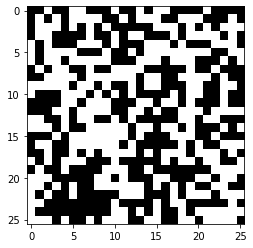

In [11]:
plt.imshow(stim[0,:].reshape(26,26), cmap='gray')

## load spike counts

In [12]:
def count_spikes(spike_times, bins, timestamp_start=0):
    num_bins = bins.shape[0]
    spike_count = np.zeros_like(bins)
    for i in range(num_bins):
        if i == 0:
            continue

        spike_count[i] = np.sum(np.logical_and(spike_times >= timestamp_start + bins[i-1], spike_times < timestamp_start + bins[i]))
    return spike_count

In [13]:
# read spike counts
path = os.path.join(data_path, 'SpikeTrain_20201209/SpikeTrain_ND2_26pix_66um_30Hz')

# load time stamps
filename = os.path.join(path, 'A1a.mat')
print(filename)
ts = sio.loadmat(filename)['A1a'].ravel()
# print(ts[0], ts[-1], ts.shape)

# load spike times
# channel_names = list()
spike_counts = list()
for i, channel_name in enumerate(tqdm(info['channel'])):
    filename = os.path.join(path, 'ch_' + channel_name)
    # print(filename)
    spike_time = sio.loadmat(filename)['ch_' + channel_name].ravel()

    # count spikes
    spike_counts.append(count_spikes(spike_time, ts))

spike_counts = np.array(spike_counts)

  0%|          | 0/85 [00:00<?, ?it/s]

data/20201209/SpikeTrain_20201209/SpikeTrain_ND2_26pix_66um_30Hz/A1a.mat


100%|██████████| 85/85 [01:59<00:00,  1.41s/it]


In [14]:
spike_counts.shape

(85, 27000)

(array([1262387.,  656835.,  256122.,   85087.,   25525.,    6820.,
           1749.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

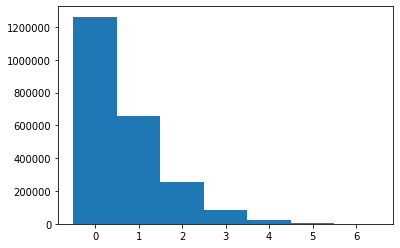

In [15]:
plt.hist(spike_counts.ravel(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

## save to npz and csv

put these files under `data`

In [16]:
np.savez(dataset, dataset=dataset, stim=stim, spike_counts=spike_counts)

In [17]:
info.to_csv(dataset+'_info.csv', index=None)